<a href="https://colab.research.google.com/github/abhi15-bose-max/StockPredictionUsingdifferentmodels/blob/main/StockPredictionusindmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance matplotlib pandas numpy scikit-learn xgboost statsmodels reservoirpy --quiet

In [ ]:
import yfinance as yf
import pandas as pd

In [ ]:
# Load Tesla stock data
df = yf.download("TSLA", start="2024-01-01", end="2025-04-01")

# Use only 'Close' price
data = df['Close'].dropna().reset_index()
data.columns = ['Date', 'Close']

# Train-test split
train = data[data['Date'] < '2025-02-01']
test = data[data['Date'] >= '2025-02-01']

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}




/tmp/ipython-input-22-1180586273.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSLA", start="2024-01-01", end="2025-04-01")
[*********************100%***********************]  1 of 1 completed


In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(dates, actual, predicted, title="Stock Price Prediction"):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label="Actual", linewidth=2)
    plt.plot(dates, predicted, label="Predicted", linewidth=2)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
#ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------ Step 1: Make series stationary (if not already) ------------------
def check_stationarity(ts):
    result = adfuller(ts)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1] < 0.05

stationary = check_stationarity(train['Close'])
if not stationary:
    diff_train = train['Close'].diff().dropna()
else:
    diff_train = train['Close']

# ------------------ Step 2: ACF and PACF for better ARIMA order ------------------
# Optional plotting for manual inspection (disable in headless runs)
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(diff_train); plot_pacf(diff_train); plt.show()

# ------------------ Step 3: Improved ARIMA model ------------------
# Try a few (p,d,q) values: use grid search if needed
best_score = float('inf')
best_order = None
best_model = None

# You can tweak this range
for p in range(0, 6):
    for d in range(0, 2):
        for q in range(0, 6):
            try:
                model = ARIMA(train['Close'], order=(p, d, q))
                fitted = model.fit()
                forecast = fitted.forecast(steps=len(test))
                error = mean_squared_error(test['Close'], forecast)
                if error < best_score:
                    best_score = error
                    best_order = (p, d, q)
                    best_model = fitted
            except:
                continue

print(f"Best ARIMA order: {best_order} with MSE: {best_score:.2f}")
metrics_arima = evaluate(test['Close'].values, pred_arima.values)

# ------------------ Step 4: Forecast and plot ------------------
pred_arima = best_model.forecast(steps=len(test))



# ------------------ Step 5: Evaluation ------------------
mae = mean_absolute_error(test['Close'], pred_arima)
mse = mean_squared_error(test['Close'], pred_arima)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


ADF Statistic: -0.09123721757167254
p-value: 0.9503043761737068


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/s

Best ARIMA order: (0, 0, 5) with MSE: 3843.19
MAE: 48.42, RMSE: 61.99


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import matplotlib.pyplot as plt

# Add Fourier features
def add_fourier_features(dates, k=3):
    t = np.arange(len(dates))
    features = []
    for i in range(1, k+1):
        features.append(np.sin(2 * np.pi * i * t / 365))
        features.append(np.cos(2 * np.pi * i * t / 365))
    return np.vstack(features).T

# Prepare data
X_train = add_fourier_features(train['Date'])
X_test = add_fourier_features(test['Date'])

# Train MLP Regressor
mlp = MLPRegressor(
    hidden_layer_sizes=(100,),
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train, train['Close'])

# Predict
pred_mlp = mlp.predict(X_test)

# Evaluate
metrics_mlp = evaluate(test['Close'].values, pred_mlp)
print("MLP + Fourier Evaluation Metrics:", metrics_mlp)

# Plot Actual vs Predicted Prices



MLP + Fourier Evaluation Metrics: {'MAE': 96.44846045773755, 'RMSE': np.float64(124.09250187579188), 'MAPE': np.float64(29.052948526599852), 'R2': -4.972839929959694}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

seq_len = 10
scaler_lstm = MinMaxScaler()
train_scaled = scaler_lstm.fit_transform(train['Close'].values.reshape(-1, 1))

X_lstm, y_lstm = [], []
for i in range(seq_len, len(train_scaled)):
    X_lstm.append(train_scaled[i-seq_len:i])
    y_lstm.append(train_scaled[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(seq_len, 1)),
    Dense(1)
])
optimizer = Adam(clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')

# Increase verbosity to keep Colab active
model.fit(X_lstm, y_lstm, epochs=50, batch_size=8, verbose=1)

# Predicting
inputs = train['Close'].values[-seq_len:].tolist()
pred_lstm = []
for _ in range(len(test)):
    scaled_input = scaler_lstm.transform(np.array(inputs[-seq_len:]).reshape(-1, 1))
    pred = model.predict(scaled_input.reshape(1, seq_len, 1), verbose=0)
    pred_inv = scaler_lstm.inverse_transform(pred)[0][0]
    pred_lstm.append(pred_inv)
    inputs.append(pred_inv)

metrics_lstm = evaluate(test['Close'].values, pred_lstm)



Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0497
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 16/50
33/33 ━━━━━━━━━━━━

In [ ]:
#XGBOOST
from xgboost import XGBRegressor

# Use previous 5 closing prices to predict next
def create_lagged_features(series, lags=5):
    df = pd.DataFrame({'y': series})
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['y'].shift(i)
    return df.dropna()

train_lag = create_lagged_features(train['Close'])
test_lag = create_lagged_features(pd.concat([train['Close'].iloc[-5:], test['Close']]))

xgb = XGBRegressor()
xgb.fit(train_lag.drop(columns='y'), train_lag['y'])

pred_xgb = xgb.predict(test_lag.drop(columns='y'))
metrics_xgb = evaluate(test_lag['y'].values, pred_xgb)

In [ ]:
#RESERVOIRCOMPUTING
from reservoirpy.nodes import Reservoir, Ridge
from sklearn.preprocessing import MinMaxScaler

# Normalize
scaler = MinMaxScaler()
X_train_rc = scaler.fit_transform(train['Close'].values.reshape(-1, 1)).flatten()

reservoir = Reservoir(100, input_dim=1, seed=42)
readout = Ridge(ridge=1e-6)
esn = reservoir >> readout

X_rc = X_train_rc[:-1].reshape(-1, 1)
Y_rc = X_train_rc[1:].reshape(-1, 1)
esn = esn.fit(X_rc, Y_rc)

# Predict
last_input = X_train_rc[-1].reshape(1, -1)
preds = []
for _ in range(len(test)):
    pred = esn.run(last_input)
    preds.append(pred[0, 0])
    last_input = pred

pred_rc = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
metrics_rc = evaluate(test['Close'].values, pred_rc)

Model: ARIMA
  MAE: 48.4198
  RMSE: 61.9934
  MAPE: 14.9844
  R2: -0.4907

Model: Reservoir
  MAE: 55.8490
  RMSE: 68.3139
  MAPE: 19.6890
  R2: -0.8101

Model: MLP+Fourier
  MAE: 96.4485
  RMSE: 124.0925
  MAPE: 29.0529
  R2: -4.9728

Model: XGBoost
  MAE: 17.4451
  RMSE: 20.0103
  MAPE: 6.0208
  R2: 0.8447

Model: LSTM
  MAE: 124.9143
  RMSE: 138.4073
  MAPE: 46.6121
  R2: -6.4303



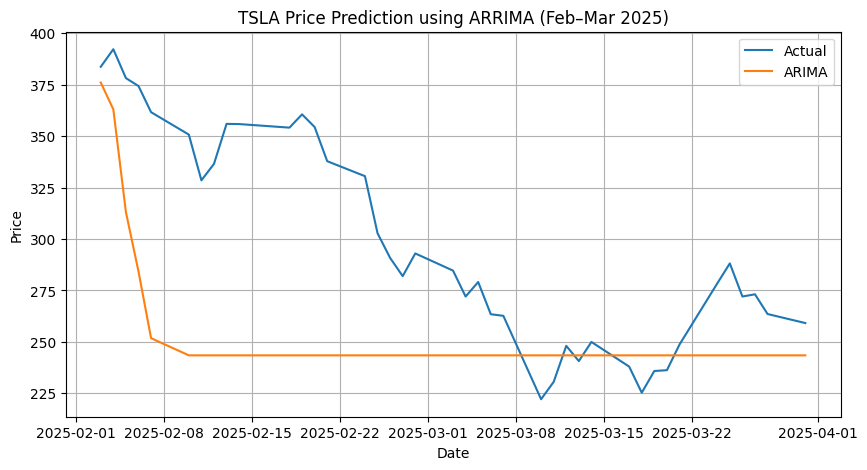

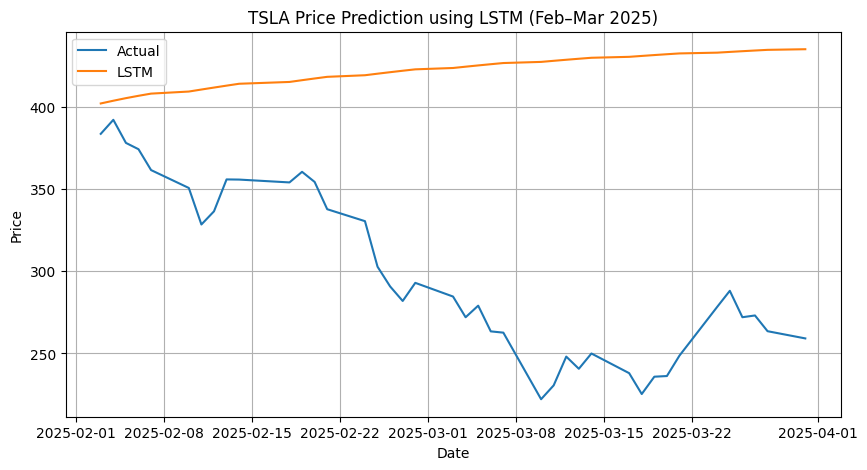

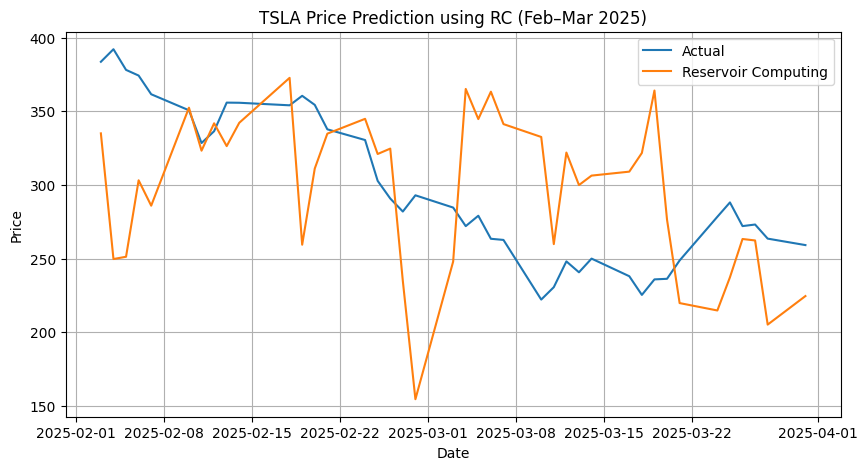

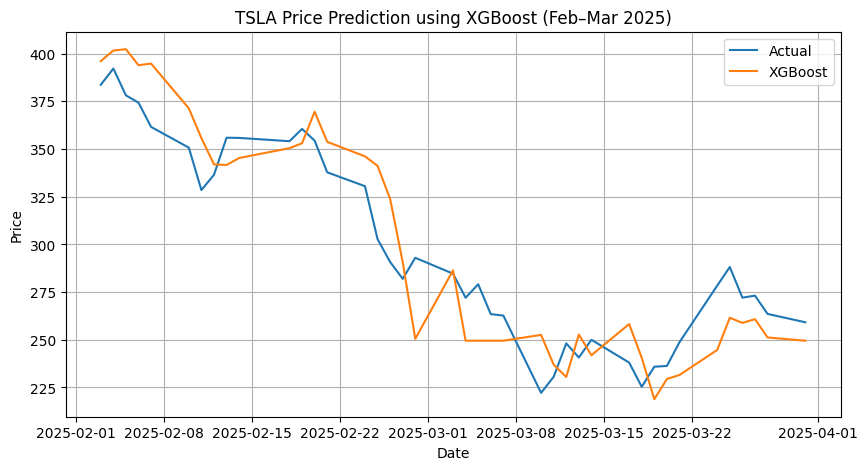

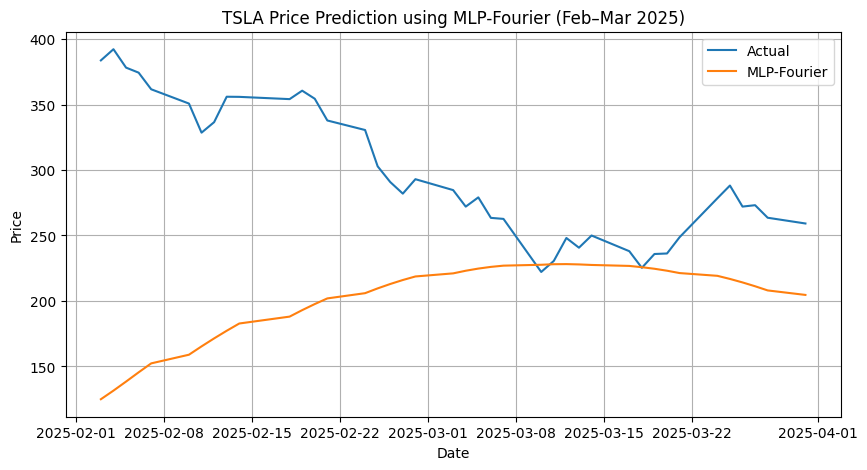

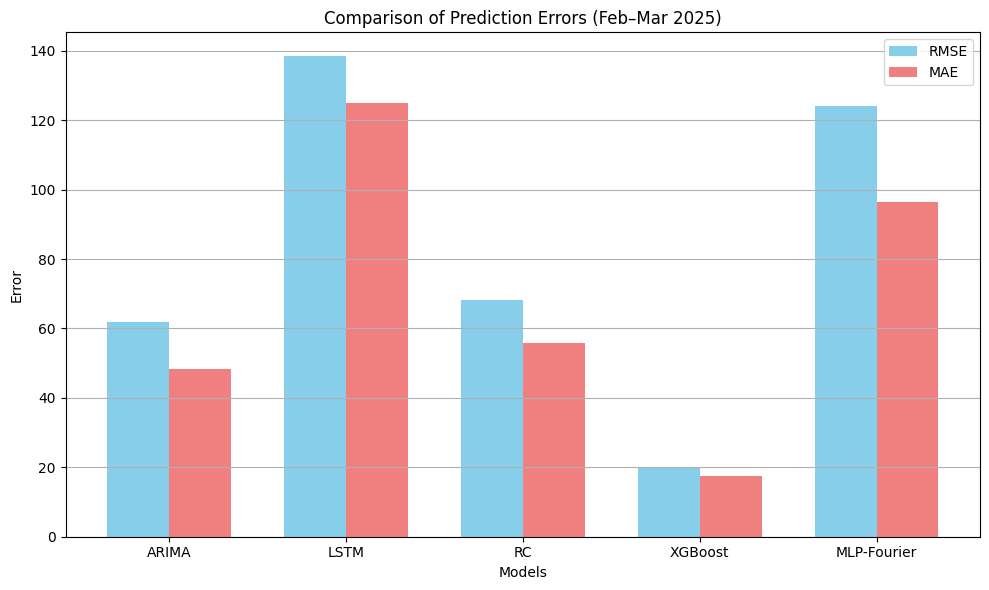

Error Summary (Feb–Mar 2025):


,RMSE,MAE
ARIMA,61.99,48.42
LSTM,138.41,124.91
RC,68.31,55.85
XGBoost,20.01,17.45
MLP-Fourier,124.09,96.45


Extended Error Summary (Feb–Mar 2025):


,RMSE,nRMSE,MAE,nMAE,MAPE (%)
ARIMA,61.993,0.208,48.420,0.163,14.984
LSTM,138.407,0.465,124.914,0.420,46.612
RC,68.314,0.230,55.849,0.188,19.689
XGBoost,20.010,0.067,17.445,0.059,6.021
MLP-Fourier,124.093,0.417,96.448,0.324,29.053


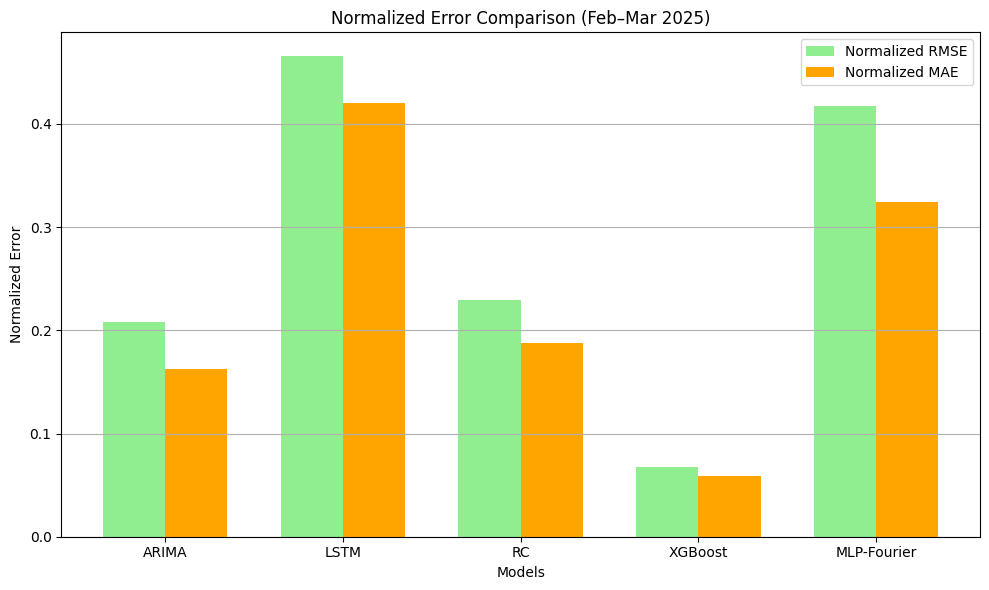

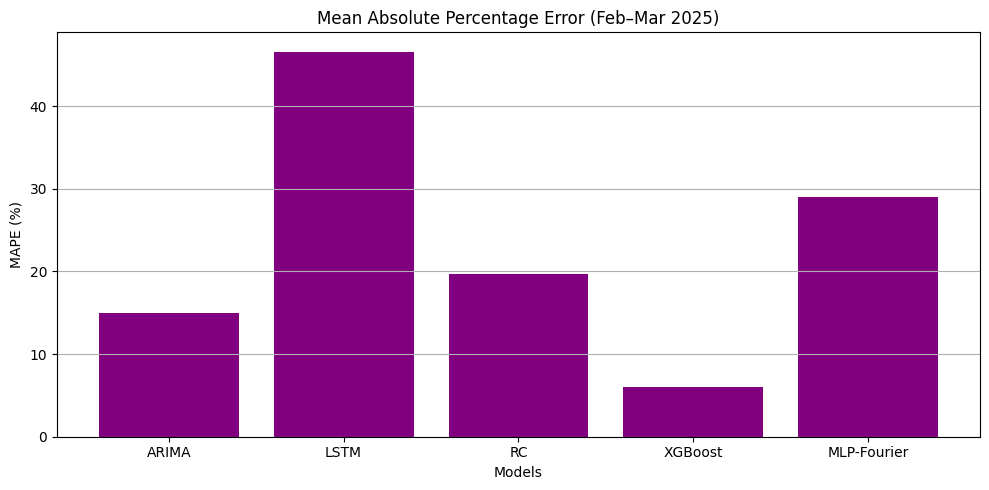

In [ ]:
import matplotlib.pyplot as plt

results = {
    "ARIMA": metrics_arima,
    "Reservoir": metrics_rc,
    "MLP+Fourier": metrics_mlp,
    "XGBoost": metrics_xgb,
    "LSTM": metrics_lstm,
}

for model, met in results.items():
    print(f"Model: {model}")
    for k, v in met.items():
        print(f"  {k}: {v:.4f}")
    print()

plt.figure(figsize=(10, 5))
plt.plot(test['Date'], test['Close'].values, label='Actual')
plt.plot(test['Date'], pred_arima, label='ARIMA')
plt.title("TSLA Price Prediction using ARRIMA (Feb–Mar 2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10, 5))
plt.plot(test['Date'], test['Close'].values, label='Actual')
plt.plot(test['Date'], pred_lstm, label='LSTM')
plt.title("TSLA Price Prediction using LSTM (Feb–Mar 2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test['Date'], test['Close'].values, label='Actual')
plt.plot(test['Date'], pred_rc, label='Reservoir Computing')
plt.title("TSLA Price Prediction using RC (Feb–Mar 2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10, 5))
plt.plot(test['Date'], test['Close'].values, label='Actual')
plt.plot(test['Date'], pred_xgb, label='XGBoost')
plt.title("TSLA Price Prediction using XGBoost (Feb–Mar 2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test['Date'], test['Close'].values, label='Actual')
plt.plot(test['Date'], pred_mlp, label='MLP-Fourier')
plt.title("TSLA Price Prediction using MLP-Fourier (Feb–Mar 2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()



from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Ground truth
y_true = test['Close'].values

# Errors
metrics = {
    'ARIMA': {
        'RMSE': np.sqrt(mean_squared_error(y_true, pred_arima)),
        'MAE': mean_absolute_error(y_true, pred_arima)
    },
    'LSTM': {
        'RMSE': np.sqrt(mean_squared_error(y_true, pred_lstm)),
        'MAE': mean_absolute_error(y_true, pred_lstm)
    },
    'RC': {
        'RMSE': np.sqrt(mean_squared_error(y_true, pred_rc)),
        'MAE': mean_absolute_error(y_true, pred_rc)
    },
    'XGBoost': {
        'RMSE': np.sqrt(mean_squared_error(y_true, pred_xgb)),
        'MAE': mean_absolute_error(y_true, pred_xgb)
    },
    'MLP-Fourier': {
        'RMSE': np.sqrt(mean_squared_error(y_true, pred_mlp)),
        'MAE': mean_absolute_error(y_true, pred_mlp)
    }
}

import matplotlib.pyplot as plt

models = list(metrics.keys())
rmse_values = [metrics[m]['RMSE'] for m in models]
mae_values = [metrics[m]['MAE'] for m in models]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue')
plt.bar(x + width/2, mae_values, width, label='MAE', color='lightcoral')

plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Comparison of Prediction Errors (Feb–Mar 2025)')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

import pandas as pd

error_df = pd.DataFrame(metrics).T
print("Error Summary (Feb–Mar 2025):")
display(error_df.round(2))

# Extended error metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Normalize errors by the mean of the true values
mean_y_true = np.mean(y_true)

for model_name, preds in {
    'ARIMA': pred_arima,
    'LSTM': pred_lstm,
    'RC': pred_rc,
    'XGBoost': pred_xgb,
    'MLP-Fourier': pred_mlp
}.items():
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)
    mape = mean_absolute_percentage_error(y_true, preds)

    metrics[model_name]['nRMSE'] = rmse / mean_y_true
    metrics[model_name]['nMAE'] = mae / mean_y_true
    metrics[model_name]['MAPE (%)'] = mape

error_df = pd.DataFrame(metrics).T
print("Extended Error Summary (Feb–Mar 2025):")
display(error_df[['RMSE', 'nRMSE', 'MAE', 'nMAE', 'MAPE (%)']].round(3))

norm_rmse_values = [metrics[m]['nRMSE'] for m in models]
norm_mae_values = [metrics[m]['nMAE'] for m in models]

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, norm_rmse_values, width, label='Normalized RMSE', color='lightgreen')
plt.bar(x + width/2, norm_mae_values, width, label='Normalized MAE', color='orange')

plt.xlabel('Models')
plt.ylabel('Normalized Error')
plt.title('Normalized Error Comparison (Feb–Mar 2025)')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

mape_values = [metrics[m]['MAPE (%)'] for m in models]

plt.figure(figsize=(10, 5))
plt.bar(models, mape_values, color='purple')
plt.xlabel('Models')
plt.ylabel('MAPE (%)')
plt.title('Mean Absolute Percentage Error (Feb–Mar 2025)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()




